In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn

### We will start off by simulating the data. We are using the constant velocity model. 

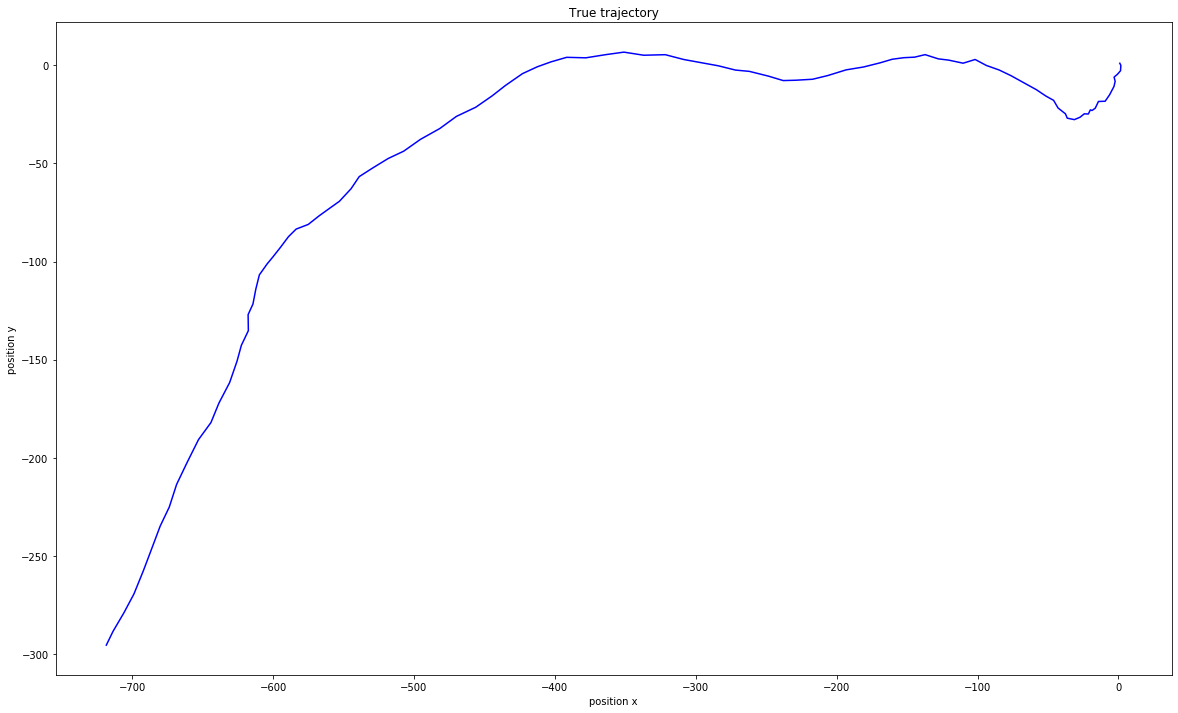

In [5]:
#We will store our real data in an array
nb_iterations=100
truth = []
#We initialise the point at x=y=0 and with null velocities
vector = np.zeros(4)
#We will display the trajectory hence we will record the position in x,y
list_x = []
list_y = []
F = np.array([[1,1,0,0], [0,1,0,0], [0,0,1,1], [0,0,0,1]])
Q = np.eye(4)
for n in range(nb_iterations):
    #The new vector is drawn as a multivariate gaussian using the current vector
    vector = np.random.multivariate_normal(np.dot(F, vector), Q)
    list_x.append(vector[0])
    list_y.append(vector[2])
    truth.append(vector)
    
#Plot the result by displaying the trajectory (x,y) over time
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("position x")
ax.set_ylabel("position y")
ax.set_title("True trajectory")
ax.plot(list_x, list_y, linestyle="-",c='b')

### Generation of noisy measurements.

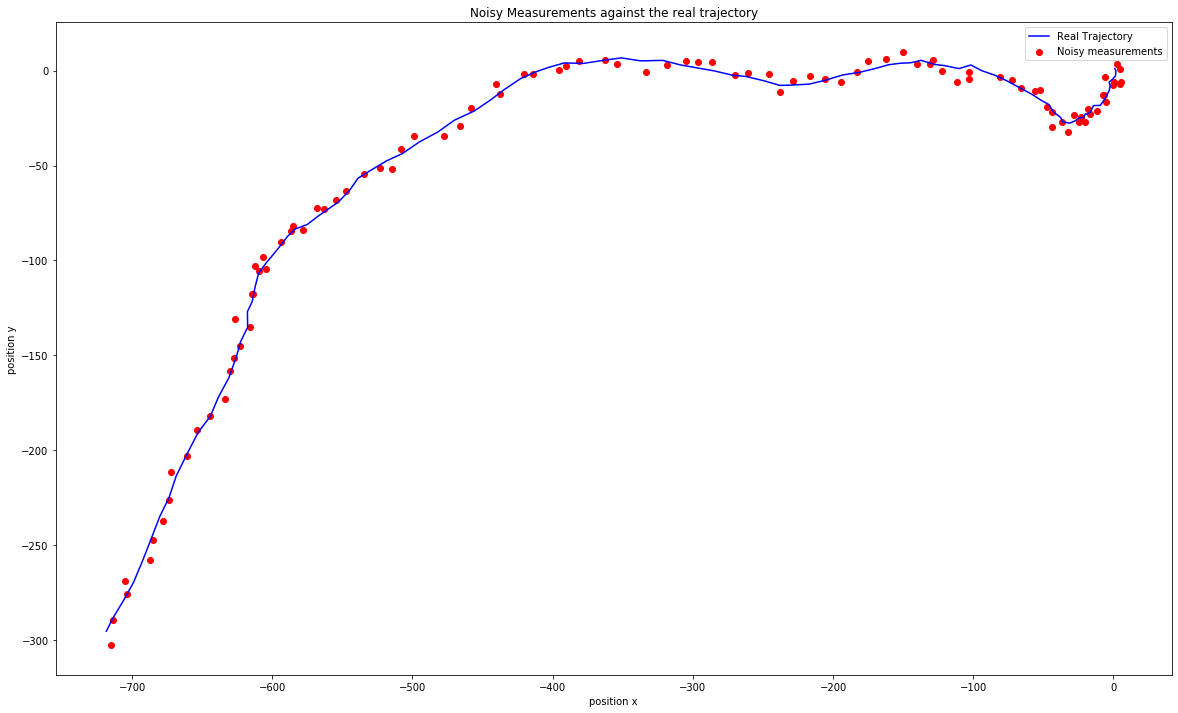

In [6]:
#We will generate a noisy set of observation of position at each time step using the real states of the process.
#We will keep only the positions (x,y), hence we will multiply the state_vector (x,vx,y,vy) by the following matrix:
H = np.array([[1,0,0,0], [0,0,1,0]]) 
#We will add a Gaussian noise of Covariance matrix
R = np.sqrt(nb_iterations) * np.eye(2)
#We will record the noisy measurements
measurements = []
noisy_list_x = []
noisy_list_y = []

for state_vector in truth:
    noisy_state = np.random.multivariate_normal(np.dot(H,state_vector),R)
    measurements.append(noisy_state)
    noisy_list_x.append(noisy_state[0])
    noisy_list_y.append(noisy_state[1])

#We plot the noisy measurements against the real trajectory   
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("position x")
ax.set_ylabel("position y")
ax.set_title("Noisy Measurements against the real trajectory")
ax.scatter(noisy_list_x, noisy_list_y, c='r', label ='Noisy measurements')
ax.plot(list_x, list_y, linestyle='-', c='b', label ='Real Trajectory')
ax.legend()

### Computing the error associated to the measurements

19.8872341972844


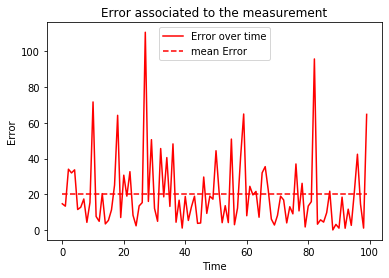

In [7]:
list_error = []
for i in range(len(measurements)):
    list_error.append((measurements[i][0] - truth[i][0])**2 + (measurements[i][1] - truth[i][2])**2)

fig=plt.figure()
ax=fig.add_subplot(1,1,1) 
ax.set_title('Error associated to the measurement')
ax.set_xlabel('Time')
ax.set_ylabel('Error')
ax.plot(list_error,c='red',label='Error over time')
ax.plot([np.mean(list_error) for i in range(len(measurements))],linestyle='--',c='red',label='mean Error')
plt.legend()
print(np.mean(list_error))

# Kalman Filter

### Implementation of the Kalman filter 

In [8]:
def Kalman(H, R, F, Q, previous_mean, previous_covariance, observation):
    #From the Kalman filter rules we know that the prediction density is a multivariate gaussian with mean and covariance
    predicted_mean = F.dot(previous_mean)
    predicted_covariance = Q + F.dot(previous_covariance).dot(F.T)
    
    #Using the predicted covariance we compute the Kalman gain K 
    K = predicted_covariance.dot(H.T).dot(np.linalg.inv(H.dot(predicted_covariance).dot(H.T) + R)) 
    
    #Also from the Kalman filter rules we know that the updated density is a multivariate gaussian with mean and covariance
    updated_mean = predicted_mean + K.dot(observation - H.dot(predicted_mean))
    updated_covariance = (np.eye(len(predicted_covariance)) - K.dot(H)).dot(predicted_covariance)
    
    return updated_mean, updated_covariance

### Using the Kalman filter to estimate trajectory using the measurements

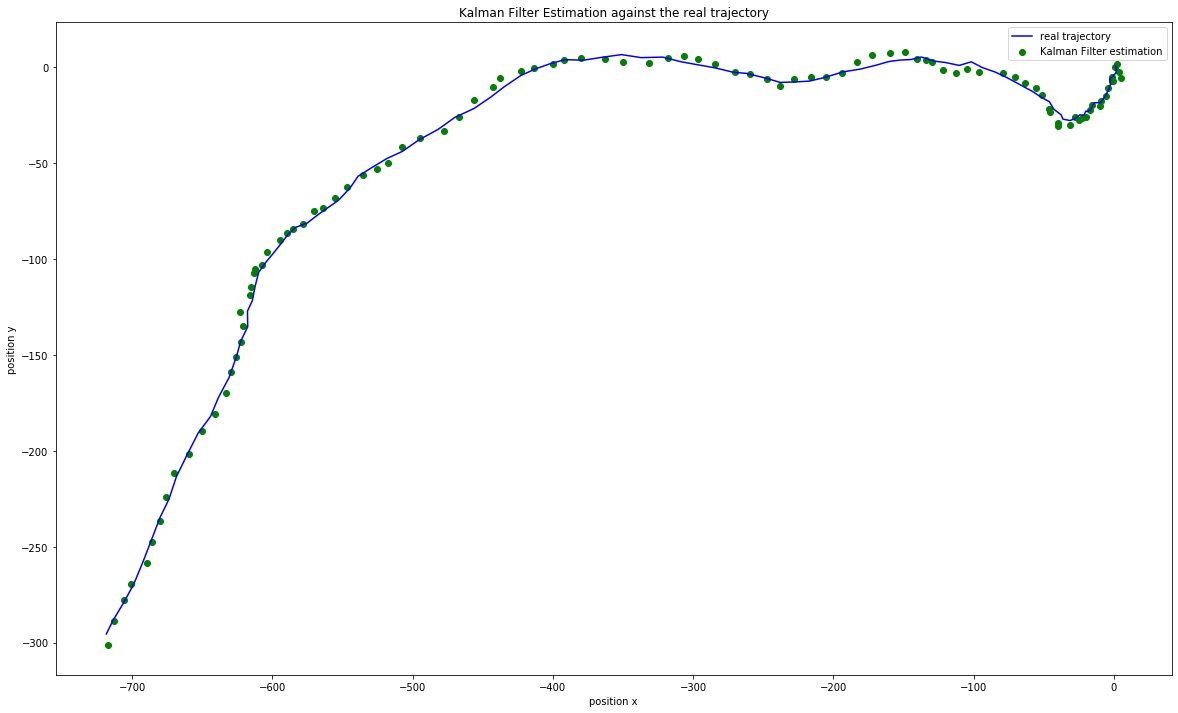

In [9]:
#We initialize the mean and the covariance
previous_mean = np.zeros(4)
previous_covariance = np.eye(4)

#We will record the updated_states which is the vector of position and velocities calculated estimated from the noisy measurement
#We will particularly be interested in the positions of the updated_state as we will use it to plot the estimated trajectory and to compute the error
updated_states=[]
updated_position_x = []
updated_position_y = []
kalman_predicted_position=[]

#Then for each measurement we will predict the position of the object using the Kalman filter rules and store the values in the lists
for measurement in measurements:
    updated_mean, updated_covariance = Kalman(H, R, F, Q , previous_mean, previous_covariance , measurement)
    previous_mean = updated_mean
    previous_covariance = updated_covariance
    updated_state = updated_mean
    kalman_predicted_position.append(np.dot(H,updated_state))
    updated_states.append(updated_state)
    updated_position_x.append(updated_state[0])
    updated_position_y.append(updated_state[2])
#We plot the estimated trajectory against the real trajectory
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("position x")
ax.set_ylabel("position y")
ax.set_title('Kalman Filter Estimation against the real trajectory')
ax.scatter(updated_position_x, updated_position_y,c='g',label='Kalman Filter estimation')
ax.plot(list_x, list_y, linestyle='-', c='b',label='real trajectory')
ax.legend()

### Computing the error associated to the Kalman Filter Estimation

11.009546578495112


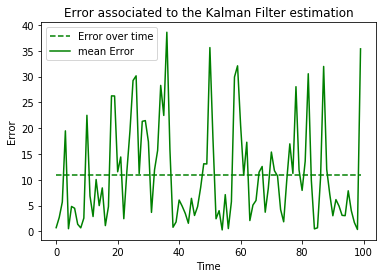

In [10]:
list_error = []
for i in range(len(kalman_predicted_position)):
    list_error.append((kalman_predicted_position[i][0] - truth[i][0])**2 + (kalman_predicted_position[i][1] - truth[i][2])**2)
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.set_title('Error associated to the Kalman Filter estimation')
ax.set_xlabel('Time')
ax.set_ylabel('Error')
ax.plot([np.mean(list_error) for i in range(len(kalman_predicted_position))],linestyle='--',c='green',label='Error over time')
ax.plot(list_error,c='green',label='mean Error')
ax.legend()
print(np.mean(list_error))

# Gaussian Sum Filter

### Implementation of the Gaussian Sum Filter

In [11]:
#We will first write a function that returns the value of the Probability Density Function of a multivariate Gaussian for a given Mean vector and covariance matrix
#This function will be convenient when we compute the PDF of a mixture of multivariate Gaussians
def compute_multivariate_gaussian_PDF(x,mean,covariance): 
    distribution=mvn(mean,covariance)
    return(distribution.pdf(x)) 

def Gaussian(H,R,F,Q,previous_weights,previous_means,previous_covariances,observation):
    #n is the number of Gaussian in the mixture model
    n=len(previous_weights)
    #From the Gaussian sum filter rules we know that the prediction density is a mixture multivariate gaussians with weights, means and covariances
    predicted_weights=[]
    predicted_means=[]
    predicted_covariances=[]
    for i in range(n):
        predicted_weights.append(previous_weights[i])
        predicted_means.append(np.array(np.dot(F,previous_means[i])))
        predicted_covariances.append(np.array(Q+np.dot(np.dot(F,previous_covariances[i]),F.T)))
     
    #Also from the Gaussian sum filter rules we know that the updated density is a mixture of multivariate gaussians with weights, means and covariances
    updated_weights=[]
    updated_means=[]
    updated_covariances=[]
    for i in range(n):
        #Using the predicted covariance for the ith Gaussian we compute the Kalman gain K for the ith Gaussian
        K = predicted_covariances[i].dot(H.T).dot(np.linalg.inv(H.dot(predicted_covariances[i]).dot(H.T) + R))
        updated_means.append(np.array(predicted_means[i] + K.dot(observation - H.dot(predicted_means[i]))))
        updated_covariances.append(np.array((np.eye(len(predicted_covariances[i])) - K.dot(H)).dot(predicted_covariances[i])))
        numerator=predicted_weights[i]*compute_multivariate_gaussian_PDF(observation,H.dot(predicted_means[i]),R+np.dot(np.dot(H,predicted_covariances[i]),H.T))
        denominator=np.sum([predicted_weights[j]*compute_multivariate_gaussian_PDF(observation,H.dot(predicted_means[j]),R+np.dot(np.dot(H,predicted_covariances[j]),H.T)) for j in range(n)])
        updated_weights.append(numerator/denominator)
    return(updated_weights,updated_means,updated_covariances)
        

### Using the Gaussian Sum Filter to estimate trajectory using the measurements

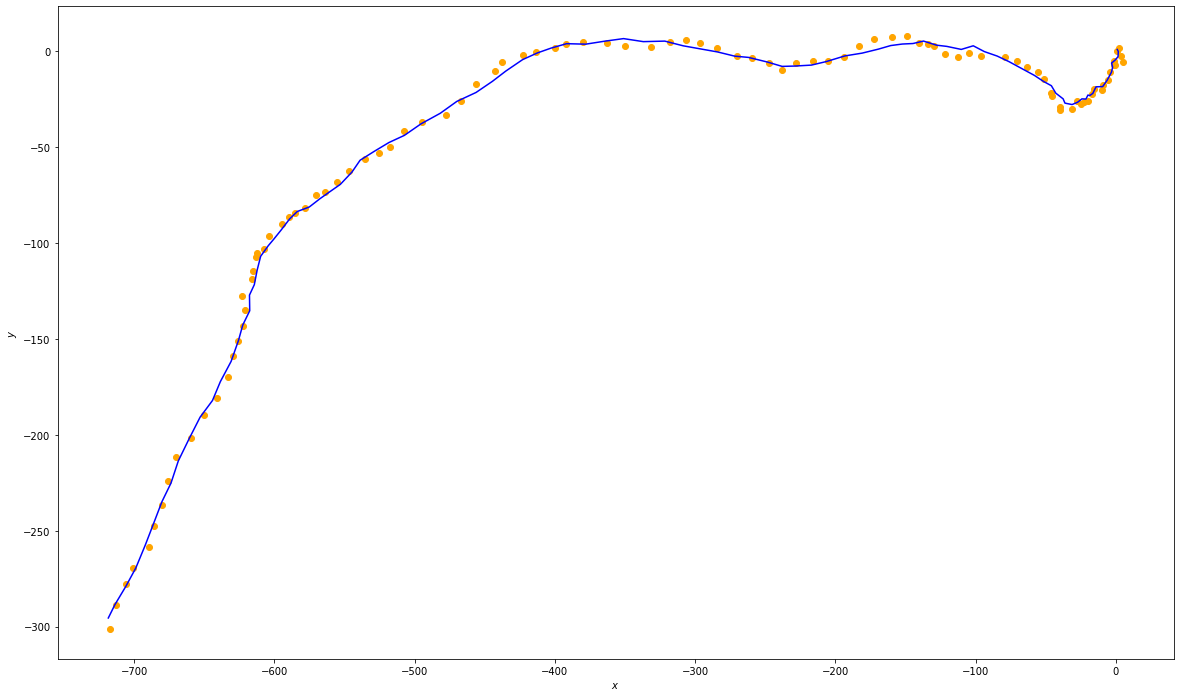

In [12]:
#We set the number of Gaussian in the mixture sum filter model
n=10
#We initialize the weights, means and covariances and store them in a list
random_uniform_vector=[np.random.uniform(0,1) for i in range(n)]
previous_weights=random_uniform_vector/np.sum(random_uniform_vector)
previous_means=[np.zeros(4) for i in range(n)]
previous_covariances=[np.eye(4) for i in range(n)]

#We will record the updated_states which is the vector of position and velocities calculated estimated from the noisy measurement
#We will particularly be interested in the positions of the updated_states as we will plot the estimated trajectory and compute the error
updated_states=[]
updated_position_x = []
updated_position_y = []
Gaussian_sum_predicted_position=[]

#Then for each measurement we will predict the position of the object using the Gaussian sum filter rules and store the values in the lists
for measurement in measurements:
    updated_weights, updated_means, updated_covariances = Gaussian(H, R, F, Q, previous_weights, previous_means , previous_covariances, measurement)
    previous_weights = updated_weights
    previous_means = updated_means
    previous_covariances = updated_covariances
    updated_state = np.sum([updated_weights[i]*updated_means[i] for i in range(len(updated_weights))],axis=0)
    updated_states.append(updated_state)
    Gaussian_sum_predicted_position.append(np.dot(H,updated_state))
    updated_position_x.append(updated_state[0])
    updated_position_y.append(updated_state[2])
    

#We plot the estimated trajectory against the real trajectory 
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(updated_position_x, updated_position_y,c='orange')
ax.plot(list_x, list_y, linestyle='-', c='b')

### Computing the error associated to the Gaussian Sum Filter estimation

11.009546578495101


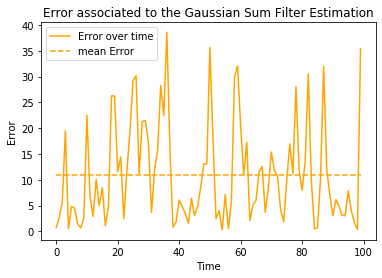

In [14]:
list_error = []
for i in range(len(Gaussian_sum_predicted_position)):
    list_error.append((Gaussian_sum_predicted_position[i][0] - truth[i][0])**2 + (Gaussian_sum_predicted_position[i][1] - truth[i][2])**2)
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.set_title('Error associated to the Gaussian Sum Filter Estimation')
ax.set_xlabel('Time')
ax.set_ylabel('Error')
ax.plot(list_error,c='orange',label='Error over time')
ax.plot([np.mean(list_error) for i in range(len(Gaussian_sum_predicted_position))],linestyle='--',c='orange',label='mean Error')
plt.legend()
print(np.mean(list_error))

## Gaussian mixture PHD filter

### Initialization

In [29]:
#We will start off by writing two functions that will be usefull for simplifying the code

#The first function gives us the value of the probability density function of a Gaussian multivariate evaluated in a given measurement
def compute_multivariate_gaussian_PDF(x,mean,covariance): 
    distribution=mvn(mean,covariance)
    return(distribution.pdf(x)) 

#The second function will allow us to drawn according to a gaussian mixture with given weights, means and covariances
def gaussian_mixture(num_simu,weights, means, covs):
    weights = weights / np.sum(weights)
    if num_simu == 0:
        return []
    idxs = [np.argmax(np.random.multinomial(1,weights)) for i in range(num_simu)]
    simus = np.array([np.random.multivariate_normal(means[idx],covs[idx]) for idx in idxs])
    return simus.reshape(num_simu,-1)

In [64]:
#Now let us define all the parameters of the Gaussian Mixture PHD filter

nb_time_steps=50
#transition parameters
F = np.array([[1,1,0,0], [0,1,0,0], [0,0,1,1], [0,0,0,1]])
Q = np.eye(4) 

#birth intensity parameters
number_components_birth=2
birth_weights = [0.1,0.1]
birth_means = [np.array([250,10,250,10]),np.array([-250,10,-250,10])]
birth_covariances  = [np.diag([100,25,100,25]),np.diag([100,25,100,25])]

#spawn intensity parameters
number_components_spawn=1
spawn_weight = 0.05
spawn_covariance = np.diag([100,400,100,400])

#survival and detection prob
survival_probability = 0.95
detection_probability = 0.95

#observation parameters 
H = np.array([[1,0,0,0],[0,0,1,0]])
R = np.sqrt(nb_iterations)*np.eye(2)

#clutter parameters
x_min=-1000
x_max=1000
y_min=-1000
y_max=1000
frame_area=(x_max-x_min)*(y_max-y_min)
clutter_value = 12.5 * 10**(-7)

def clutter(z):
    if z[0]>=x_min and z[0]<=x_max and z[1]>=y_min and z[1]<=y_max:
        return(clutter_value)
    else:
        return(0)

#initial_points: fixed or random number of points with position uniformly distributed over the window and with null speed.
number_points= np.random.randint(low = 0,high = 5)
'''number_points=2'''
initial_points = [np.array([np.random.uniform(x_min,x_max),0,np.random.uniform(y_min,y_max),0]) for i in range(number_points)]

#We initialize the parameters of the Beta component
w_B = [spawn_weight]
F_B = [np.eye(4)]
Q_B  = [spawn_covariance]    

### Simulating the trajectory

In [65]:
#We will write a function that generates a trajectory with multiple points
def generate_true_trajectory(nb_time_steps, initial_points, F, Q, birth_weights, 
               birth_means, birth_cov, spawn_weight, spawn_cov, survival_probability):
    #The function will return a list of list of vector states
    points = [initial_points]
    birth_intensity = np.sum(birth_weights)
    spawn_intensity = spawn_weight 
    trajectory = [initial_points]
    for i in range(1,nb_time_steps):
        new_points = []
        for point in trajectory[-1]:
            try_survival=np.random.binomial(1,survival_probability)
            if try_survival ==1:
                current_points=[np.random.multivariate_normal(np.dot(F,point),Q)]
            else:
                current_points = []
            current_points = np.array(current_points).reshape(1,-1)
            #We will draw the number of points to spawn from the current point
            number_spawns = np.random.poisson(spawn_intensity)
            if number_spawns > 0:
                spawned_points = np.random.multivariate_normal(point, spawn_covariance, number_spawns)
                if current_points.size == 0:
                    current_points = spawned_points
                    new_points.append(current_points)
                else:
                    current_points = np.vstack((current_points,spawned_points))
                    new_points.append(current_points)
            else:
                if current_points != []:
                    new_points.append(current_points)
        number_births = np.random.poisson(birth_intensity)
        birthed_points = gaussian_mixture(number_births,birth_weights,birth_means,birth_covariances)
        if birthed_points != []: 
            new_points.append(birthed_points)
        if new_points != []:
            trajectory.append(np.vstack(new_points))
    return trajectory

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


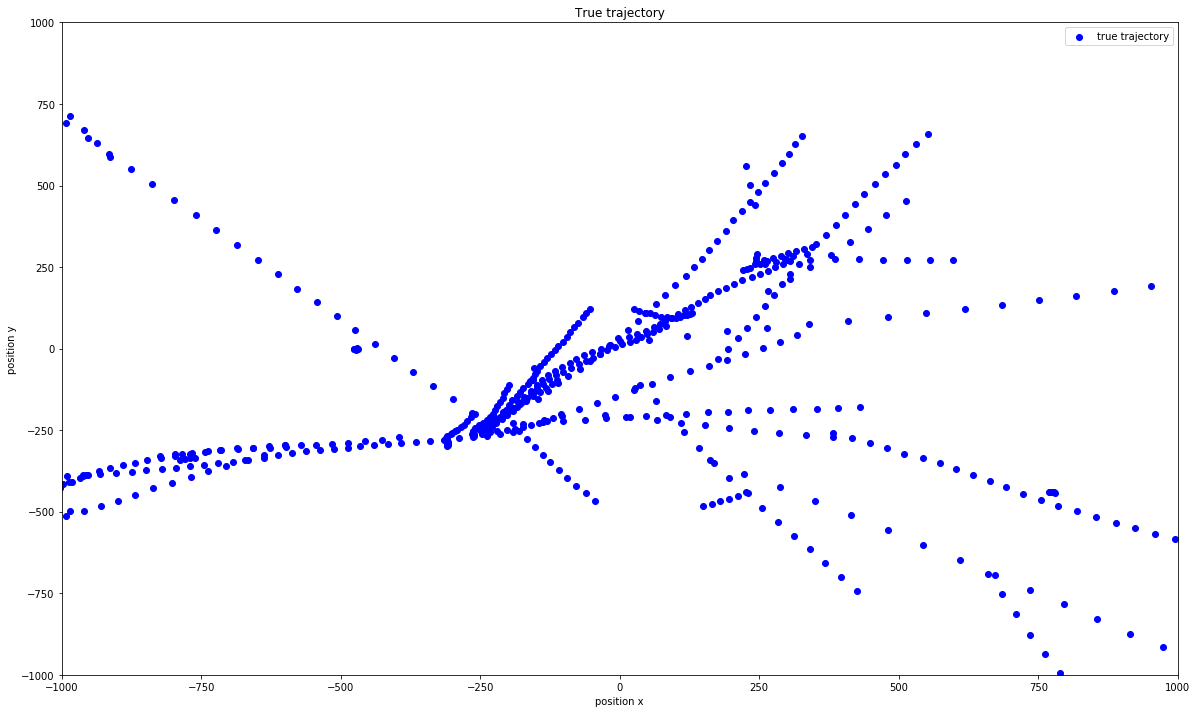

In [66]:
truth = generate_true_trajectory(nb_time_steps, initial_points, F, Q, birth_weights, birth_means, birth_covariances, 
                    spawn_weight, spawn_covariance, survival_probability)

truth_plot = np.vstack(truth[1:])

#Plot the result by displaying the trajectory (x,y) over time
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([x_min,x_max])
ax.set_ylim([y_min,y_max])
ax.set_xlabel("position x")
ax.set_ylabel("position y")
ax.set_title("True trajectory")
ax.scatter(truth_plot[:,0], truth_plot[:,2],c='b',label="true trajectory")
ax.legend()

## Generating Noisy Measurements

In [72]:
#We will write a function that generates a noisy position measurement of the trajectory with false alarm observations
def generate_noisy_measurements(truth, H, R, clutter_lambda, detection_probability):
    #The function will return a list of lists of noisy position observations
    measurements = []
    for i in range(len(truth)):
        measurement = []
        #We draw the number of false alarm observations according to a poisson distribution
        number_clutter = np.random.poisson(clutter_lambda)
        #Then we distribution our number of clutter uniformely in the frame
        clutter = np.random.uniform(-1000,1000,(number_clutter,2))
        measurement.append(clutter)
        for state in truth[i]:
            #Then for each point, if the point is detected we draw a noisy measurement of the point 
            if np.random.binomial(1,detection_probability) == 1:
                noisy_state = np.random.multivariate_normal(np.dot(H,state), R)
                measurement.append(noisy_state)
        measurements.append(np.vstack(measurement))
    return measurements

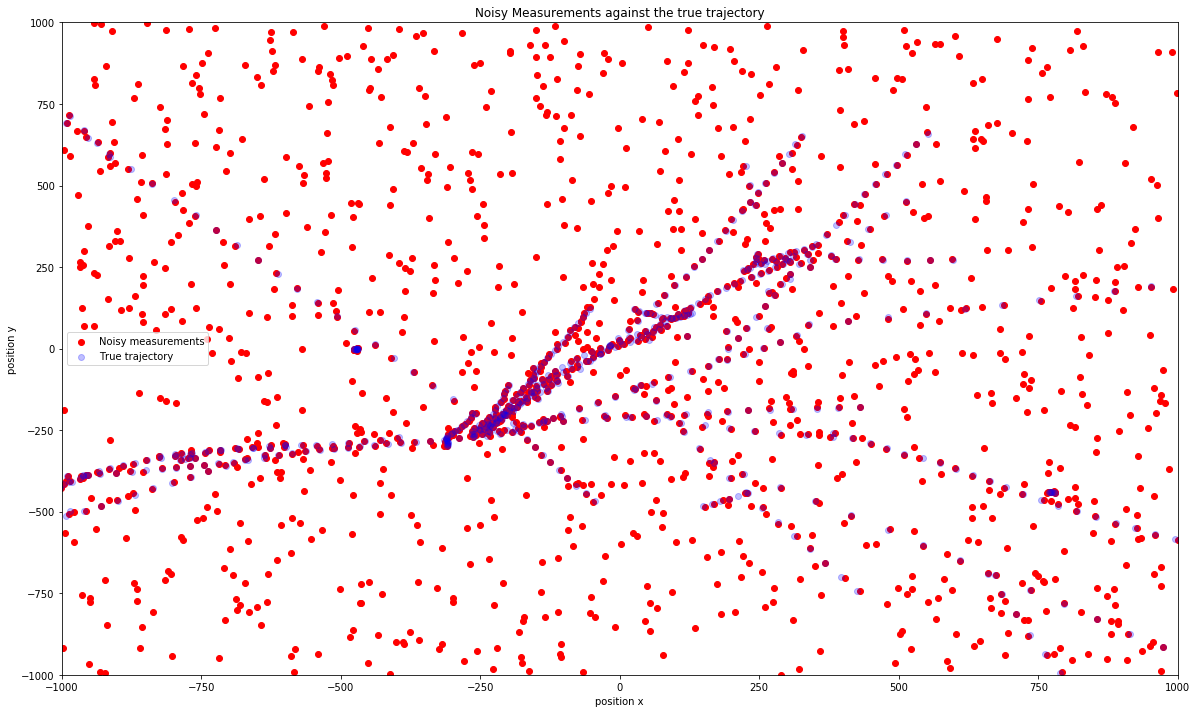

In [73]:
list_measurements = generate_noisy_measurements(truth, H, R, 20, 0.99)

measurements_plot = np.vstack(list_measurements[1:])

#We plot the noisy measurements  
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([x_min,x_max])
ax.set_ylim([y_min,y_max])
ax.set_xlabel("position x")
ax.set_ylabel("position y")
ax.set_title("Noisy Measurements against the true trajectory")
ax.scatter(measurements_plot[:,0],measurements_plot[:,1], c='r', label = 'Noisy measurements')
ax.scatter(truth_plot[:,0], truth_plot[:,2],c='b',label="True trajectory",alpha=0.25)
ax.legend()

### Implementation of the Gaussian mixture PHD filter

In [74]:
def PHD(H,R,F,Q,previous_weights,previous_means, previous_covariances,measurements,birth_weights,birth_means,birth_covariances,survival_probability,detection_probability):
    #We will start by computing the predicted intensity parameters
    #The parameters of the survival component of the predicted intensity
    survival_weights=[survival_probability*previous_weight for previous_weight in previous_weights]
    survival_means=[np.dot(F,previous_mean) for previous_mean in previous_means]
    survival_covariances=[Q + np.dot(F,np.dot(previous_covariance,F.T)) for previous_covariance in previous_covariances]
    #The parameters for the component Beta are: 
    beta_weights = [previous_weights[j] * w_B[l] for j in range(len(previous_means))
                for l in range(len(w_B))]
    beta_means   = [np.dot(F_B[l],previous_means[j]) for j in range(len(previous_means))
                for l in range(len(F_B))]
    beta_covariances = [Q_B[l] + np.dot(F_B[l], np.dot(previous_covariances[j],F_B[l].T)) for j in range(len(previous_means))
                for l in range(len(Q_B))]
    #The parameters of the predicted intensity are therefore: 
    predicted_weights=survival_weights + birth_weights + beta_weights
    predicted_means=survival_means + birth_means + beta_means
    predicted_covariances=survival_covariances + birth_covariances + beta_covariances
     
    #Now for the update parameters
    sum_measurements_weights=[]
    sum_measurements_means=[]
    sum_measurements_covariances=[]
    for measurement in measurements:
        list_q=[compute_multivariate_gaussian_PDF(measurement, np.dot(H,predicted_means[i]),R+np.dot(H,np.dot(predicted_covariances[i],H.T))) for i in range(len(predicted_weights))]
        list_K= [np.dot(np.dot(predicted_covariances[i],H.T),np.linalg.inv(R+np.dot(H,np.dot(predicted_covariances[i],H.T)))) for i in range(len(predicted_weights))]
        measurement_weights=[detection_probability*predicted_weights[i]*list_q[i]/(clutter(measurement) + detection_probability * np.sum([predicted_weights[j]*list_q[j] for j in range(len(predicted_weights))])) for i in range(len(predicted_weights))]
        measurement_means=[predicted_means[i] + np.dot(list_K[i],measurement - np.dot(H,predicted_means[i])) for i in range(len(predicted_weights))]
        measurement_covariances=[np.dot(np.eye(4) - np.dot(list_K[i],H),predicted_covariances[i]) for i in range(len(predicted_weights))]
        sum_measurements_weights+=measurement_weights
        sum_measurements_means+=measurement_means
        sum_measurements_covariances+=measurement_covariances
    updated_weights=[(1-detection_probability)*predicted_weight for predicted_weight in predicted_weights] + sum_measurements_weights
    updated_means=predicted_means+sum_measurements_means
    updated_covariances=predicted_covariances+sum_measurements_covariances
    return(updated_weights,updated_means,updated_covariances)

### Using the Gaussian mixture PHD filter to estimate the trajectory using the measurements

In [75]:
#We initialize the weights,means and covariances 
previous_weights = np.random.uniform(0,2,len(initial_points))
previous_means = initial_points
previous_covariances = [np.diag([100,100,25,25]) for i in range(len(initial_points))]

updated_states=[]
Gaussian_sum_predicted_position=[]

for measurements in list_measurements:
    updated_weights, updated_means, updated_covariances = PHD(H, R, F, Q, previous_weights, previous_means , previous_covariances,measurements,birth_weights,birth_means,birth_covariances,survival_probability,detection_probability)
    selected_weights= []
    selected_means= []
    selected_covariances=[]
    for i in range(len(updated_weights)):
        if updated_weights[i]>0.005:
            selected_weights.append(updated_weights[i])
            selected_means.append(updated_means[i])
            selected_covariances.append(updated_covariances[i])
    previous_weights=selected_weights
    previous_means=selected_means
    previous_covariances=selected_covariances
    estimates=selected_means
    updated_states.append(estimates)

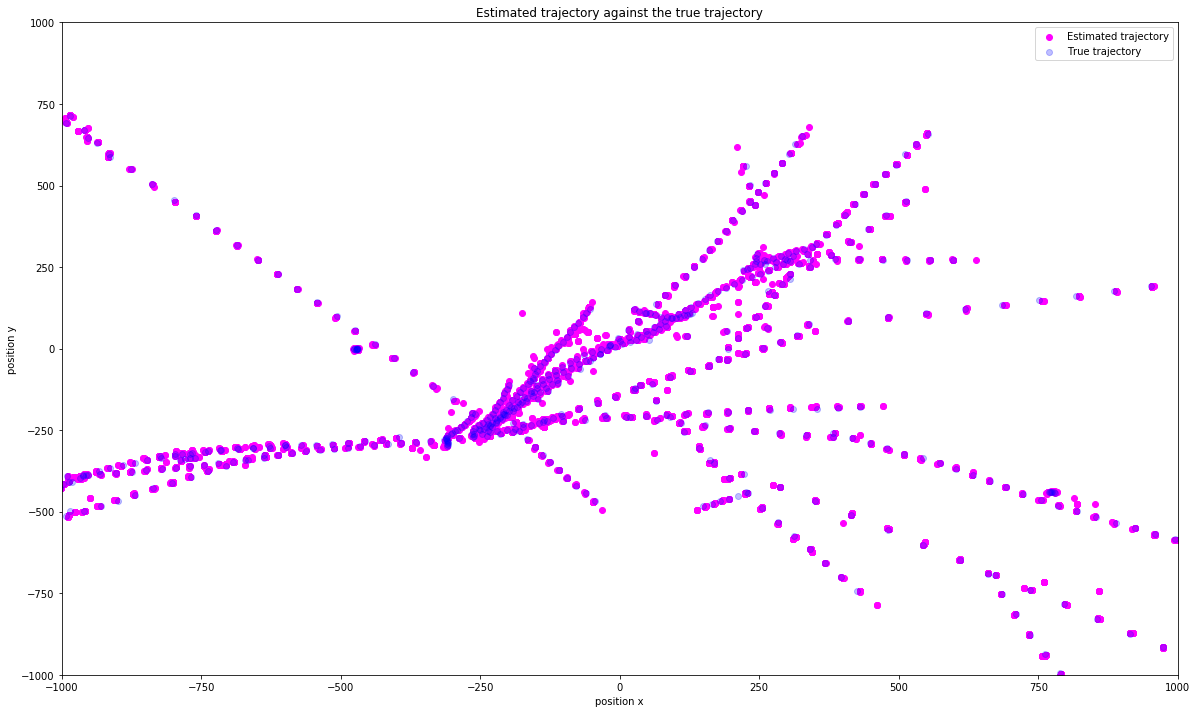

In [76]:
#We plot the trajectory estimated using the Gaussian Mixture PHD filter
updated_states_plot=np.vstack(updated_states[1:])

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([x_min,x_max])
ax.set_ylim([y_min,y_max])
ax.set_xlabel("position x")
ax.set_ylabel("position y")
ax.set_title("Estimated trajectory against the true trajectory")
ax.scatter(updated_states_plot[:,0],updated_states_plot[:,2], c='magenta', label = 'Estimated trajectory')
ax.scatter(truth_plot[:,0], truth_plot[:,2],c='b',label="True trajectory",alpha=0.25)
ax.legend()